# IEEE-CIS Fraud Detection - Classifications

## Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from PIL import Image
from functions.balance_dataset import balance_dataset 
from functions.test_hyperparameters import test_hyperparameters 
from functions.create_classifier import create_classifier, plot_confusion_matrix 
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import random

import warnings
warnings.filterwarnings("ignore")

## Config

In [2]:
SEED_VAL = 42
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)

## Read files

In [3]:
# !unzip '../data/train_transaction.zip' -d '../data'

In [4]:
transaction_df = pd.read_csv("../data/train_transaction.csv")

In [5]:
print(transaction_df.shape)

(590540, 394)


In [6]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing

### Preprocess attributes

All columns

In [7]:
print(transaction_df.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

Remove NaN values

In [8]:
transaction_df = transaction_df.replace(np.nan, 0)

Limit to 5000 samples

In [9]:
transaction_df_samples = transaction_df.sample(n=5000, random_state=SEED_VAL)

X_df = transaction_df_samples.drop('isFraud', axis=1)
y_df = transaction_df_samples['isFraud']

Transform categorical attributes on dummy variables

Categorical features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

In [10]:
ProductCD_data = pd.get_dummies(X_df['ProductCD']).add_prefix('ProductCD_')
P_emaildomain_data = pd.get_dummies(X_df['P_emaildomain']).add_prefix('P_emaildomain_')
R_emaildomain_data = pd.get_dummies(X_df['R_emaildomain']).add_prefix('R_emaildomain_')

card1_data = pd.get_dummies(X_df['card1']).add_prefix('card1_')
card2_data = pd.get_dummies(X_df['card2']).add_prefix('card2_')
card3_data = pd.get_dummies(X_df['card3']).add_prefix('card3_')
card4_data = pd.get_dummies(X_df['card4']).add_prefix('card4_')
card5_data = pd.get_dummies(X_df['card5']).add_prefix('card5_')
card6_data = pd.get_dummies(X_df['card6']).add_prefix('card6_')

addr1_data = pd.get_dummies(X_df['addr1']).add_prefix('addr1_')
addr2_data = pd.get_dummies(X_df['addr2']).add_prefix('addr2_')

M1_data = pd.get_dummies(X_df['M1']).add_prefix('M1_')
M2_data = pd.get_dummies(X_df['M2']).add_prefix('M2_')
M3_data = pd.get_dummies(X_df['M3']).add_prefix('M3_')
M4_data = pd.get_dummies(X_df['M4']).add_prefix('M4_')
M5_data = pd.get_dummies(X_df['M5']).add_prefix('M5_')
M6_data = pd.get_dummies(X_df['M6']).add_prefix('M6_')
M7_data = pd.get_dummies(X_df['M7']).add_prefix('M7_')
M8_data = pd.get_dummies(X_df['M8']).add_prefix('M8_')
M9_data = pd.get_dummies(X_df['M9']).add_prefix('M9_')

X_df = X_df[X_df.columns.drop(['TransactionID','ProductCD', 'P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'])]

X_df = pd.concat([X_df, ProductCD_data, P_emaildomain_data, R_emaildomain_data, 
                    card1_data, card2_data, card3_data, card4_data, card5_data, card6_data,
                    addr1_data, addr2_data,
                    M1_data, M2_data, M3_data, M4_data, M5_data, M6_data, M7_data, M8_data, M9_data], join = 'outer', axis=1)


In [11]:
X_df.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,M6_T,M7_0,M7_F,M7_T,M8_0,M8_F,M8_T,M9_0,M9_F,M9_T
470624,12153579,724.000,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,...,1,0,1,0,0,1,0,0,0,1
565820,15005886,108.500,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,...,1,0,0,1,0,0,1,0,0,1
284083,6970178,47.950,6.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,...,0,1,0,0,1,0,0,1,0,0
239689,5673658,100.599,0.0,0.0,2.0,3.0,0.0,1.0,0.0,1.0,...,0,1,0,0,1,0,0,1,0,0
281855,6886780,107.950,0.0,0.0,10.0,14.0,0.0,0.0,11.0,8.0,...,1,1,0,0,1,0,0,1,0,0


In [12]:
X_df.shape

(5000, 2570)

### Split dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=SEED_VAL)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED_VAL)

print('Shape of train dataset', X_train.shape)
print('Shape of validation dataset', X_val.shape)
print('Shape of test dataset', X_test.shape)

Shape of train dataset (3000, 2570)
Shape of validation dataset (1000, 2570)
Shape of test dataset (1000, 2570)


### Balance dataset - choose %

Analyzing the proportion of fraudulent samples:

In [14]:
y_train.value_counts(normalize=True)

0    0.964333
1    0.035667
Name: isFraud, dtype: float64

The fraudulent samples are approximately 4% of the dataset, so we are dealing with an unbalanced dataset.

Define not balanced dataset

In [15]:
X_train_not_balanced_04 = X_train
y_train_not_balanced_04 = y_train

##### Define balanced dataset using oversampling

In [16]:
X_train_balanced_10, y_train_balanced_10 = balance_dataset('oversampling', X_train, y_train, 0.112) # 10% fraud
X_train_balanced_20, y_train_balanced_20 = balance_dataset('oversampling', X_train, y_train, 0.251) # 20% fraud
X_train_balanced_30, y_train_balanced_30 = balance_dataset('oversampling', X_train, y_train, 0.43)  # 30% fraud
X_train_balanced_40, y_train_balanced_40 = balance_dataset('oversampling', X_train, y_train, 0.667) # 40% fraud
X_train_balanced_50, y_train_balanced_50 = balance_dataset('oversampling', X_train, y_train, 1)     # 50% fraud

print('10%:')
print('X_train.shape', X_train_balanced_10.shape)

print('\n20%:')
print('X_train.shape', X_train_balanced_20.shape)

print('\n30%:')
print('X_train.shape', X_train_balanced_30.shape)

print('\n40%:')
print('X_train.shape', X_train_balanced_40.shape)

print('\n50%:')
print('X_train.shape', X_train_balanced_50.shape)

10%:
X_train.shape (3217, 2570)

20%:
X_train.shape (3619, 2570)

30%:
X_train.shape (4136, 2570)

40%:
X_train.shape (4822, 2570)

50%:
X_train.shape (5786, 2570)


In [17]:
y_train_balanced_50.value_counts(normalize=True)

0    0.5
1    0.5
Name: isFraud, dtype: float64

##### Define balanced dataset using undersampling

In [17]:
X_train_balanced_us_10, y_train_balanced_us_10 = balance_dataset('undersampling', X_train, y_train, 0.112) # 10% fraud
X_train_balanced_us_20, y_train_balanced_us_20 = balance_dataset('undersampling', X_train, y_train, 0.251) # 20% fraud
X_train_balanced_us_30, y_train_balanced_us_30 = balance_dataset('undersampling', X_train, y_train, 0.43)  # 30% fraud
X_train_balanced_us_40, y_train_balanced_us_40 = balance_dataset('undersampling', X_train, y_train, 0.667) # 40% fraud
X_train_balanced_us_50, y_train_balanced_us_50 = balance_dataset('undersampling', X_train, y_train, 1)     # 50% fraud

print('10%:')
print('X_train.shape', X_train_balanced_us_10.shape)

print('\n20%:')
print('X_train.shape', X_train_balanced_us_20.shape)

print('\n30%:')
print('X_train.shape', X_train_balanced_us_30.shape)

print('\n40%:')
print('X_train.shape', X_train_balanced_us_40.shape)

print('\n50%:')
print('X_train.shape', X_train_balanced_us_50.shape)

10%:
X_train.shape (1062, 2570)

20%:
X_train.shape (533, 2570)

30%:
X_train.shape (355, 2570)

40%:
X_train.shape (267, 2570)

50%:
X_train.shape (214, 2570)


In [25]:
y_train_balanced_us_50.value_counts(normalize=True)

0    0.5
1    0.5
Name: isFraud, dtype: float64

##### Normalize data for Naive Bayes

In [18]:
scaler = MinMaxScaler()

X_train_not_balanced_04_normalized = scaler.fit(X_train_not_balanced_04).transform(X_train_not_balanced_04)

X_train_balanced_10_normalized = scaler.fit(X_train_balanced_10).transform(X_train_balanced_10)
X_train_balanced_20_normalized = scaler.fit(X_train_balanced_20).transform(X_train_balanced_20)
X_train_balanced_30_normalized = scaler.fit(X_train_balanced_30).transform(X_train_balanced_30)
X_train_balanced_40_normalized = scaler.fit(X_train_balanced_40).transform(X_train_balanced_40)
X_train_balanced_50_normalized = scaler.fit(X_train_balanced_50).transform(X_train_balanced_50)

X_train_balanced_us_10_normalized = scaler.fit(X_train_balanced_us_10).transform(X_train_balanced_us_10)
X_train_balanced_us_20_normalized = scaler.fit(X_train_balanced_us_20).transform(X_train_balanced_us_20)
X_train_balanced_us_30_normalized = scaler.fit(X_train_balanced_us_30).transform(X_train_balanced_us_30)
X_train_balanced_us_40_normalized = scaler.fit(X_train_balanced_us_40).transform(X_train_balanced_us_40)
X_train_balanced_us_50_normalized = scaler.fit(X_train_balanced_us_50).transform(X_train_balanced_us_50)

X_val_normalized = scaler.fit(X_val).transform(X_val)

X_test_normalized = scaler.fit(X_test).transform(X_test)

#### Classification - original data (0.04%)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       959
           1       0.10      0.49      0.16        41

    accuracy                           0.79      1000
   macro avg       0.53      0.65      0.52      1000
weighted avg       0.94      0.79      0.85      1000

Confusion Matrix: 


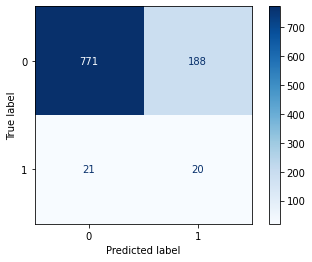

In [ ]:
nb_clf = MultinomialNB(alpha=1)

y_pred = create_classifier(nb_clf, X_train_not_balanced_04_normalized, y_train_not_balanced_04, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.00      0.00        41

    accuracy                           0.96      1000
   macro avg       0.98      0.50      0.49      1000
weighted avg       0.96      0.96      0.94      1000

Confusion Matrix: 


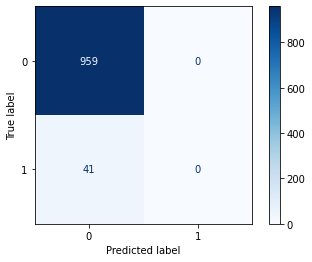

In [ ]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_not_balanced_04, y_train_not_balanced_04, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.15      0.26        41

    accuracy                           0.96      1000
   macro avg       0.98      0.57      0.62      1000
weighted avg       0.97      0.96      0.95      1000

Confusion Matrix: 


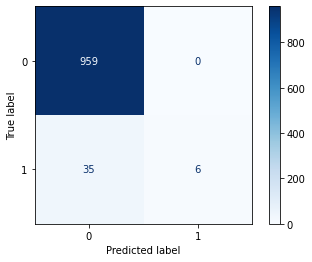

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=None, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_not_balanced_04, y_train_not_balanced_04, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       0.50      0.05      0.09        41

    accuracy                           0.96      1000
   macro avg       0.73      0.52      0.53      1000
weighted avg       0.94      0.96      0.94      1000

Confusion Matrix: 


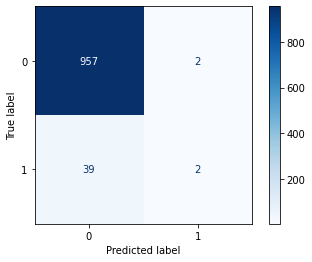

In [ ]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(500,), alpha=1, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_not_balanced_04, y_train_not_balanced_04, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

#### Classification - oversampling data

##### Test Hyperparameters

PCA unbalanced (4% fraud)

In [24]:
test_hyperparameters('Naive Bayes', X_train_not_balanced_04_normalized, y_train_not_balanced_04)
test_hyperparameters('SVM', X_train_not_balanced_04, y_train_not_balanced_04)
test_hyperparameters('Random Forest', X_train_not_balanced_04, y_train_not_balanced_04)
test_hyperparameters('Multilayer Perceptron', X_train_not_balanced_04, y_train_not_balanced_04)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 1}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (20,), 'alpha': 0.01, 'activation': 'relu'}


PCA unbalanced (10% fraud)

In [25]:
test_hyperparameters('Naive Bayes', X_train_balanced_10_normalized, y_train_balanced_10)
test_hyperparameters('SVM', X_train_balanced_10, y_train_balanced_10)
test_hyperparameters('Random Forest', X_train_balanced_10, y_train_balanced_10)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_10, y_train_balanced_10)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 100}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (500,), 'alpha': 0.01, 'activation': 'relu'}


PCA unbalanced (20% fraud)

In [26]:
test_hyperparameters('Naive Bayes', X_train_balanced_20_normalized, y_train_balanced_20)
test_hyperparameters('SVM', X_train_balanced_20, y_train_balanced_20)
test_hyperparameters('Random Forest', X_train_balanced_20, y_train_balanced_20)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_20, y_train_balanced_20)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 10}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'alpha': 0.01, 'activation': 'tanh'}


PCA unbalanced (30% fraud)

In [27]:
test_hyperparameters('Naive Bayes', X_train_balanced_30_normalized, y_train_balanced_30)
test_hyperparameters('SVM', X_train_balanced_30, y_train_balanced_30)
test_hyperparameters('Random Forest', X_train_balanced_30, y_train_balanced_30)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_30, y_train_balanced_30)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 0.1, 'activation': 'relu'}


PCA unbalanced (40% fraud)

In [28]:
test_hyperparameters('Naive Bayes', X_train_balanced_40_normalized, y_train_balanced_40)
test_hyperparameters('SVM', X_train_balanced_40, y_train_balanced_40)
test_hyperparameters('Random Forest', X_train_balanced_40, y_train_balanced_40)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_40, y_train_balanced_40)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 10}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (500,), 'alpha': 0.001, 'activation': 'relu'}


PCA unbalanced (50% fraud)

In [29]:
test_hyperparameters('Naive Bayes', X_train_balanced_50_normalized, y_train_balanced_50)
test_hyperparameters('SVM', X_train_balanced_50, y_train_balanced_50)
test_hyperparameters('Random Forest', X_train_balanced_50, y_train_balanced_50)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_50, y_train_balanced_50)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'rbf', 'C': 100}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 0.0001, 'activation': 'relu'}


##### Classificate (10% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       959
           1       0.11      0.51      0.18        41

    accuracy                           0.80      1000
   macro avg       0.54      0.66      0.53      1000
weighted avg       0.94      0.80      0.86      1000

Confusion Matrix: 


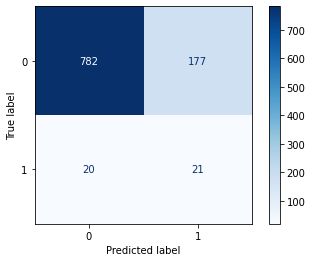

In [36]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_10_normalized, y_train_balanced_10, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.00      0.00        41

    accuracy                           0.96      1000
   macro avg       0.98      0.50      0.49      1000
weighted avg       0.96      0.96      0.94      1000

Confusion Matrix: 


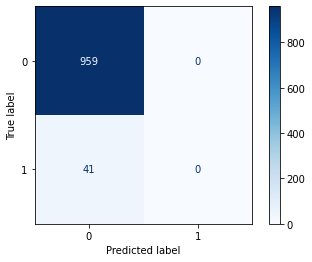

In [21]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       959
           1       1.00      0.22      0.36        41

    accuracy                           0.97      1000
   macro avg       0.98      0.61      0.67      1000
weighted avg       0.97      0.97      0.96      1000

Confusion Matrix: 


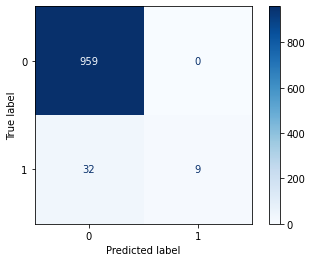

In [22]:
rf_clf = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       959
           1       0.44      0.10      0.16        41

    accuracy                           0.96      1000
   macro avg       0.70      0.55      0.57      1000
weighted avg       0.94      0.96      0.94      1000

Confusion Matrix: 


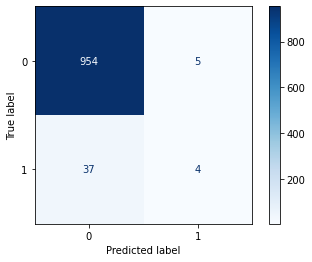

In [23]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(500,), alpha=1, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (20% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       959
           1       0.11      0.51      0.18        41

    accuracy                           0.81      1000
   macro avg       0.54      0.67      0.54      1000
weighted avg       0.94      0.81      0.86      1000

Confusion Matrix: 


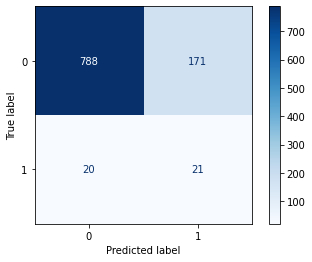

In [41]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_20_normalized, y_train_balanced_20, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.00      0.00        41

    accuracy                           0.96      1000
   macro avg       0.98      0.50      0.49      1000
weighted avg       0.96      0.96      0.94      1000

Confusion Matrix: 


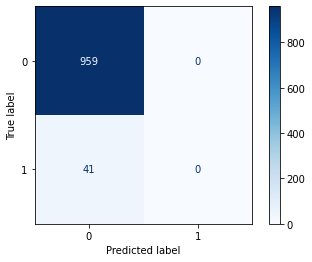

In [24]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       959
           1       1.00      0.22      0.36        41

    accuracy                           0.97      1000
   macro avg       0.98      0.61      0.67      1000
weighted avg       0.97      0.97      0.96      1000

Confusion Matrix: 


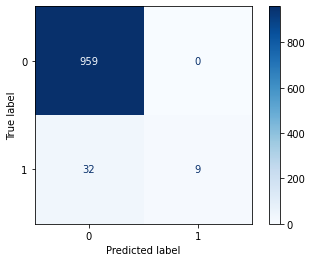

In [19]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=40, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       959
           1       0.33      0.10      0.15        41

    accuracy                           0.95      1000
   macro avg       0.65      0.54      0.56      1000
weighted avg       0.94      0.95      0.94      1000

Confusion Matrix: 


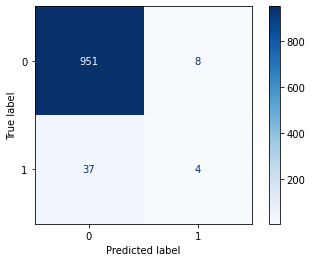

In [20]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(40,), alpha=0.01, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_20, y_train_balanced_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (30% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       959
           1       0.11      0.51      0.18        41

    accuracy                           0.81      1000
   macro avg       0.54      0.67      0.54      1000
weighted avg       0.94      0.81      0.86      1000

Confusion Matrix: 


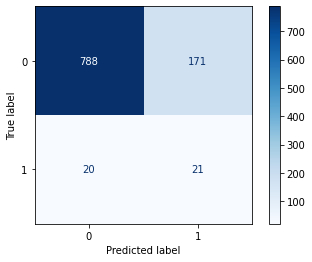

In [45]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_30_normalized, y_train_balanced_30, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.00      0.00        41

    accuracy                           0.96      1000
   macro avg       0.98      0.50      0.49      1000
weighted avg       0.96      0.96      0.94      1000

Confusion Matrix: 


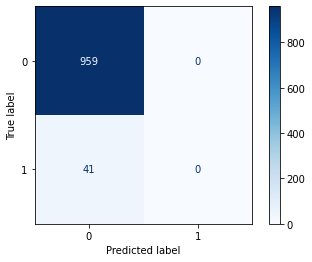

In [21]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_30, y_train_balanced_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       0.86      0.15      0.25        41

    accuracy                           0.96      1000
   macro avg       0.91      0.57      0.62      1000
weighted avg       0.96      0.96      0.95      1000

Confusion Matrix: 


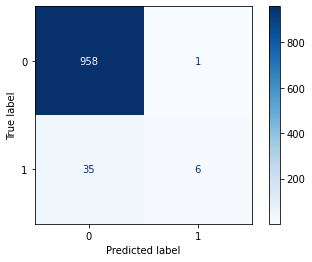

In [22]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=40, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_30, y_train_balanced_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.00      0.00        41

    accuracy                           0.96      1000
   macro avg       0.98      0.50      0.49      1000
weighted avg       0.96      0.96      0.94      1000

Confusion Matrix: 


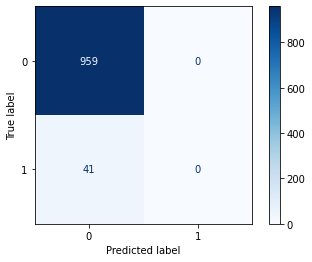

In [23]:
mlp_clf = MLPClassifier(solver='sgd', learning_rate='constant', hidden_layer_sizes=(80,), alpha=0.0001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_30, y_train_balanced_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (40% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       959
           1       0.11      0.51      0.18        41

    accuracy                           0.81      1000
   macro avg       0.54      0.67      0.54      1000
weighted avg       0.94      0.81      0.86      1000

Confusion Matrix: 


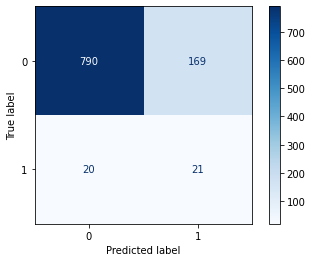

In [52]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_40_normalized, y_train_balanced_40, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.00      0.00        41

    accuracy                           0.96      1000
   macro avg       0.98      0.50      0.49      1000
weighted avg       0.96      0.96      0.94      1000

Confusion Matrix: 


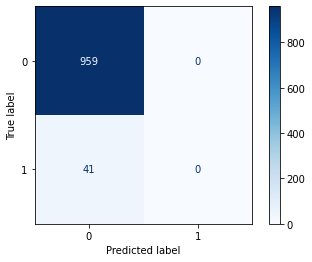

In [32]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_40, y_train_balanced_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       959
           1       1.00      0.15      0.26        41

    accuracy                           0.96      1000
   macro avg       0.98      0.57      0.62      1000
weighted avg       0.97      0.96      0.95      1000

Confusion Matrix: 


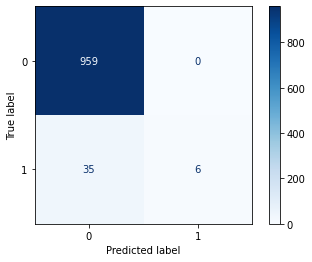

In [24]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=60, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_40, y_train_balanced_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       959
           1       0.32      0.15      0.20        41

    accuracy                           0.95      1000
   macro avg       0.64      0.57      0.59      1000
weighted avg       0.94      0.95      0.94      1000

Confusion Matrix: 


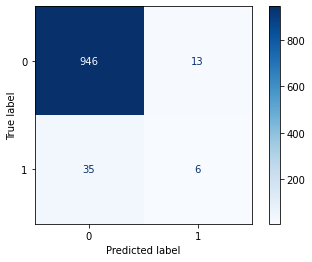

In [33]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_40, y_train_balanced_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (50% fraud)

Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       959
           1       0.11      0.51      0.18        41

    accuracy                           0.81      1000
   macro avg       0.54      0.67      0.54      1000
weighted avg       0.94      0.81      0.86      1000

Confusion Matrix: 


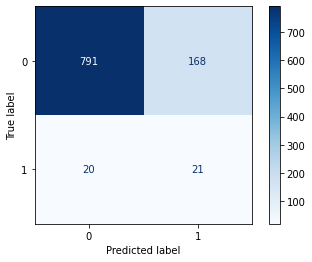

In [56]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_50_normalized, y_train_balanced_50, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       959
           1       0.03      0.12      0.05        41

    accuracy                           0.80      1000
   macro avg       0.49      0.48      0.47      1000
weighted avg       0.92      0.80      0.86      1000

Confusion Matrix: 


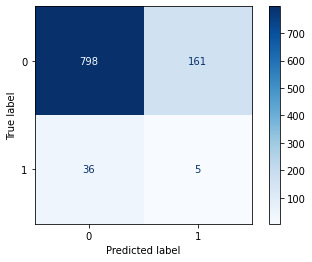

In [28]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_50, y_train_balanced_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       959
           1       0.80      0.20      0.31        41

    accuracy                           0.96      1000
   macro avg       0.88      0.60      0.65      1000
weighted avg       0.96      0.96      0.95      1000

Confusion Matrix: 


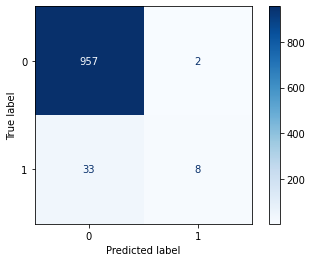

In [30]:
rf_clf = RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=100, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_50, y_train_balanced_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       959
           1       0.15      0.32      0.21        41

    accuracy                           0.90      1000
   macro avg       0.56      0.62      0.58      1000
weighted avg       0.94      0.90      0.92      1000

Confusion Matrix: 


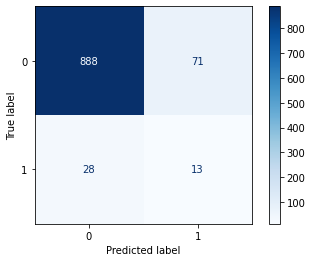

In [31]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_50, y_train_balanced_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

#### Classification - undersampling data

##### Test Hyperparameters

PCA unbalanced (10% fraud)

In [19]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_10_normalized, y_train_balanced_us_10)
test_hyperparameters('SVM', X_train_balanced_us_10, y_train_balanced_us_10)
test_hyperparameters('Random Forest', X_train_balanced_us_10, y_train_balanced_us_10)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_10, y_train_balanced_us_10)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 1}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (40,), 'alpha': 1, 'activation': 'relu'}


PCA unbalanced (20% fraud)

In [20]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_20_normalized, y_train_balanced_us_20)
test_hyperparameters('SVM', X_train_balanced_us_20, y_train_balanced_us_20)
test_hyperparameters('Random Forest', X_train_balanced_us_20, y_train_balanced_us_20)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_20, y_train_balanced_us_20)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1000}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'alpha': 1, 'activation': 'relu'}


PCA unbalanced (30% fraud)

In [21]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_30_normalized, y_train_balanced_us_30)
test_hyperparameters('SVM', X_train_balanced_us_30, y_train_balanced_us_30)
test_hyperparameters('Random Forest', X_train_balanced_us_30, y_train_balanced_us_30)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_30, y_train_balanced_us_30)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80, 'criterion': 'entropy'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (300,), 'alpha': 1, 'activation': 'tanh'}


PCA unbalanced (40% fraud)

In [22]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_40_normalized, y_train_balanced_us_40)
test_hyperparameters('SVM', X_train_balanced_us_40, y_train_balanced_us_40)
test_hyperparameters('Random Forest', X_train_balanced_us_40, y_train_balanced_us_40)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_40, y_train_balanced_us_40)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}


PCA unbalanced (50% fraud)

In [23]:
test_hyperparameters('Naive Bayes', X_train_balanced_us_50_normalized, y_train_balanced_us_50)
test_hyperparameters('SVM', X_train_balanced_us_50, y_train_balanced_us_50)
test_hyperparameters('Random Forest', X_train_balanced_us_50, y_train_balanced_us_50)
test_hyperparameters('Multilayer Perceptron', X_train_balanced_us_50, y_train_balanced_us_50)

Best hyperparameters based on f1 score for Naive Bayes: {'alpha': 0.0001}
Best hyperparameters based on f1 score for SVM: {'kernel': 'sigmoid', 'C': 1}
Best hyperparameters based on f1 score for Random Forest: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'gini'}
Best hyperparameters based on f1 score for Multilayer Perceptron: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (500,), 'alpha': 0.0001, 'activation': 'tanh'}


##### Classificate (10% fraud)

Naive Bayes

In [ ]:
nb_clf = MultinomialNB(alpha=1)

y_pred = create_classifier(nb_clf, X_train_balanced_us_10_normalized, y_train_balanced_us_10, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_10, y_train_balanced_us_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_10, y_train_balanced_us_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

In [ ]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(500,), alpha=1, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_10, y_train_balanced_us_10, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (20% fraud)

Naive Bayes

In [ ]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_us_20_normalized, y_train_balanced_us_20, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_20, y_train_balanced_us_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=40, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_20, y_train_balanced_us_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

In [ ]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(40,), alpha=0.01, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_20, y_train_balanced_us_20, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (30% fraud)

Naive Bayes

In [ ]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_us_30_normalized, y_train_balanced_us_30, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_30, y_train_balanced_us_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=40, criterion='entropy', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_30, y_train_balanced_us_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

In [ ]:
mlp_clf = MLPClassifier(solver='sgd', learning_rate='constant', hidden_layer_sizes=(80,), alpha=0.0001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_30, y_train_balanced_us_30, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (40% fraud)

Naive Bayes

In [ ]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_us_40_normalized, y_train_balanced_us_40, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_40, y_train_balanced_us_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=60, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_40, y_train_balanced_us_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

In [ ]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_40, y_train_balanced_us_40, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

##### Classificate (50% fraud)

Naive Bayes

In [ ]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_us_50_normalized, y_train_balanced_us_50, 
                          X_val_normalized, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_val_normalized, y_val)

Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='poly', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_us_50, y_train_balanced_us_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_val, y_val)

Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=100, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_us_50, y_train_balanced_us_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_val, y_val)

Multilayer Perceptron

In [ ]:
mlp_clf = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.001, activation='relu', random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_us_50, y_train_balanced_us_50, 
                          X_val, y_val)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_val, y_val)

#### Results

In [ ]:
x_axis = ['0.3%', '1%', '10%', '20%', '30%', '40%', '50%']

fig = make_subplots(rows=1, cols=3, shared_xaxes=True, subplot_titles=['Fraud', 'Not fraud', 'Accuracy'], x_title='Balanced (%)', y_title='F1-score')

fig.add_traces([go.Scatter(x=x_axis, y=[0, 0, 0.07, 0.57, 0.81, 0.89, 0.92], name='Naive Bayes', line=dict(color="#46C756")),
                go.Scatter(x=x_axis, y=[0.82, 0.89, 1, 1, 1, 1, 1], name='Support Vector Machine', line=dict(color="#FF69B4")),
                go.Scatter(x=x_axis, y=[0.8, 1, 1, 0.98, 1, 1, 1], name='Random Forest', line=dict(color="#2E7890"))], rows=[1,1,1], cols=[1,1,1])

fig.add_traces([go.Scatter(x=x_axis, y=[1, 0.99, 0.95, 0.93, 0.94, 0.94, 0.93], line=dict(color="#46C756"), showlegend=False),
                go.Scatter(x=x_axis, y=[1, 1, 1, 1, 1, 1, 1], line=dict(color="#FF69B4"), showlegend=False),
                go.Scatter(x=x_axis, y=[1, 1, 1, 1, 1, 1, 1], line=dict(color="#2E7890"), showlegend=False)], rows=[1,1,1], cols=[2,2,2])

fig.add_traces([go.Scatter(x=x_axis, y=[0.99, 0.99, 0.91, 0.87, 0.90, 0.92, 0.92], line=dict(color="#46C756"), showlegend=False),
                go.Scatter(x=x_axis, y=[1, 1, 1, 1, 1, 1, 1], line=dict(color="#FF69B4"), showlegend=False),
                go.Scatter(x=x_axis, y=[1, 1, 1, 0.99, 1, 1, 1], line=dict(color="#2E7890"), showlegend=False)], rows=[1,1,1], cols=[3,3,3])

fig.update_layout(
plot_bgcolor = 'white',
font = {'family': 'Arial','size': 14,'color': '#37363d'})

fig.update_xaxes( showgrid=True, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray',
showline=True, linewidth=1, linecolor='black')

fig.show()

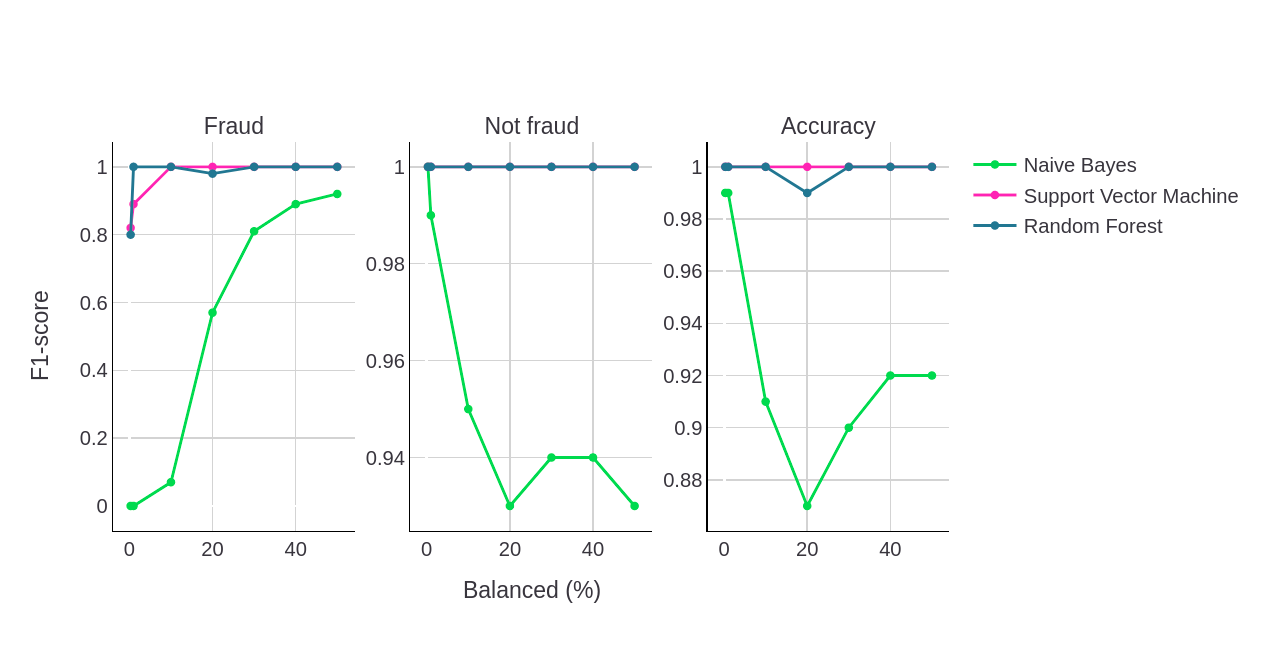

In [ ]:
classification_results = Image.open('results/classification_results.png')
classification_results

## Classification

### Balance dataset

In [ ]:
X_train_balanced_10, y_train_balanced_10 = balance_dataset(X_train, y_train, 0.112) # 10% fraud

print('10%:')
print('X_train.shape', X_train_balanced_10.shape)

### Normalize data for Naive Bayes

In [ ]:
scaler = MinMaxScaler()

X_train_balanced_10_normalized = scaler.fit(X_train_balanced_10).transform(X_train_balanced_10)
X_val_normalized = scaler.fit(X_val).transform(X_val)
X_test_normalized = scaler.fit(X_test).transform(X_test)

### Classificate

#### Naive Bayes

In [ ]:
nb_clf = MultinomialNB(alpha=0.0001)

y_pred = create_classifier(nb_clf, X_train_balanced_10_normalized, y_train_balanced_10, 
                          X_test_normalized, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(nb_clf, X_test_normalized, y_test)

#### Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='rbf', C=1, random_state=SEED_VAL)

y_pred = create_classifier(svm_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_test, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(svm_clf, X_test, y_test)

#### Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=5, criterion='gini', random_state=SEED_VAL)

y_pred = create_classifier(rf_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_test, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(rf_clf, X_test, y_test)

#### Multilayer Perceptron

In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.001, random_state=SEED_VAL)

y_pred = create_classifier(mlp_clf, X_train_balanced_10, y_train_balanced_10, 
                          X_test, y_test)

print('Confusion Matrix: ')
plot_confusion_matrix(mlp_clf, X_test, y_test)